# Purpose
The purpose of this notebook is to collect the raw data and perform analyses required to generate Figure 2.

# Preliminaries

## load packages

In [3]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import re
import os
import glob
from pathlib import Path
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, Normalize

#data
import numpy as np
import pandas as pd
import random
import ast
import pickle
import networkx as nx
import community
from datetime import datetime, timedelta, time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

# custom modules
from src import parameters,rfid, plot
from src import timestamps
from src import preprocess


Autosaving every 60 seconds


## set paths

In [4]:
# project root - to reproduce, change root to the full path to wild-mus-vocal-ecology
root = 'path/to/wild-mus-vocal-ecology'

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
all_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data from 2013-2023 ("all")

# path to adult phenotypes (sex)
sexes_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')
demography_metadata_path = os.path.join(root, 'data', 'phenotypes', 'All_popul_checks_update2023_transponder-and-popchecks.csv')

# path to data on litters born
pups_metadata_path = os.path.join(root, 'data', 'phenotypes', 'pups.csv')

## get sex and transponder ID data

In [5]:
# make a dictionary mapping transponder ID to sex
sexes = pd.read_csv(sexes_path, low_memory=False)
sex_dict = sexes.set_index('transponder_ID')['Sex'].to_dict()

# color them
sex_colors = {}
sex_colors['M'] = 'tomato'
sex_colors['F'] = 'skyblue'
sex_colors[float('NaN')] = 'grey'

# Get the raw data

In [1]:
# stays by individual
stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid,  'mouse_stays', '*.feather'))])
stays = stays.rename(columns={'box_number':'box'})
stays = preprocess.raw_data_from_cloud_of_mice(stays, df_type='stays')
stays['season'] = ['summer' if (i.month in [6,7,8]) else \
                   'autumn' if i.month in [9,10,11] else \
                   'winter' if i.month in [12,1,2] else \
                   'spring' for i in stays['entry_time']]
stays = stays[stays['time_in_secs'] > 0] # drop the 4 stays with negative stay length

# stays by box
box_events = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(all_rfid, 'box_events', '*.feather'))])
box_events = preprocess.raw_data_from_cloud_of_mice(box_events, df_type='box_events')   
box_events['year'] = box_events['event_time'].dt.year
box_events['month'] = box_events['event_time'].dt.month
box_events['season'] = ['summer' if (i.month in [6,7,8]) else \
                       'autumn' if i.month in [9,10,11] else \
                       'winter' if i.month in [12,1,2] else \
                       'spring' for i in box_events['event_time']]

#pups 2013-2023
pups = pd.read_csv(pups_metadata_path)

In [5]:
# define start and end of data
dataset_start, dataset_end = pd.to_datetime('2013-01-01 00:00:00'), pd.to_datetime('2024-01-01 00:00:00')

#subset by start and end
stays = stays[(stays['entry_time'] >= dataset_start) & 
              (stays['exit_time'] <= dataset_end)]
box_events = box_events[(box_events['event_time'] >= dataset_start) & 
                        (box_events['event_time'] <= dataset_end)]

# minimum stay to consider for the purpose of this figure 
min_stay = 0.01

# add sex and stay time in minutes for convenience
stays['time_in_secs'] = stays['time_in_secs'].astype(float)
stays['time_in_minutes'] = stays['time_in_secs']/(60)
stays['sex'] = stays['transponder_id'].astype(int).map(sex_dict)

# drop odd numbered boxes after winter 2020 
# these are readings from RFID readers that are connected to RFID system but no longer attached to boxes
stays = stays[~((stays['box'] % 2 != 0) & (stays['year'] >= 2021))]
box_events = box_events[~((box_events['box'] % 2 != 0) & (box_events['year'] >= 2021))]

# Organize the raw data

## Get the number of mice

In [2]:
demography = pd.read_csv(demography_metadata_path)
print(f"Between {dataset_start} and {dataset_end}, the number of adult mice in the barn \nranged between {demography['Total mice'].min()} and {demography['Total mice'].max()}")

## Get the time between first and last stay

In [7]:
# Group by transponder_id and aggregate to get first entry_time and last exit_time
first_last_stays = stays.groupby('transponder_id').agg(first_entry_time=('entry_time', 'min'),
                                                       last_exit_time=('exit_time', 'max'), 
                                                       sex=('sex','first')).reset_index()

# add detection time and add a column for units in days, season
first_last_stays['detection_time'] = first_last_stays['last_exit_time'] - first_last_stays['first_entry_time']
first_last_stays['detection_time_days'] = first_last_stays['detection_time'].dt.days
first_last_stays['first_stay_season'] = ['summer' if (i.month in [6,7,8]) else \
                       'autumn' if i.month in [9,10,11] else \
                       'winter' if i.month in [12,1,2] else \
                       'spring' for i in first_last_stays['first_entry_time']]
first_last_stays['last_stay_season'] = ['summer' if (i.month in [6,7,8]) else \
                       'autumn' if i.month in [9,10,11] else \
                       'winter' if i.month in [12,1,2] else \
                       'spring' for i in first_last_stays['last_exit_time']]

# only consider mice whose last exit was before 1 year prior to the last exit detected in this dataset
# why: if we haven't seen the mouse for 1 year, we assume here that it is gone, hence possible to assin a "last" exit
first_last_stays = first_last_stays[first_last_stays['last_exit_time'] <= dataset_end - pd.DateOffset(years=1)]


In [3]:
first_last_stays['detection_time_days'].mean()
print(f"Between {dataset_start} and {dataset_end - pd.DateOffset(years=1)}\n the average mouse was detected for {first_last_stays['detection_time_days'].mean()} days between first and last detection.")



In [4]:
first_last_stays['detection_time_days'].mean()
print(f"Between {dataset_start} and {dataset_end - pd.DateOffset(years=1)}\n the average mouse was detected for {first_last_stays['detection_time_days'].mean()} days between first and last detection.")



## Get sunrises and sunsets

In [10]:
# get sunrise and sunset times
zurich = [47.38, 8.57]
sunrises = timestamps.get_sunrises(location = zurich, 
                                   start_date = dataset_start, 
                                   end_date = dataset_end)
sunsets = timestamps.get_sunsets(location = zurich, 
                                 start_date = dataset_start, 
                                 end_date = dataset_end)

stays['entry_date'] = stays['entry_time'].dt.date
stays['exit_date'] = stays['exit_time'].dt.date
stays['entry_sunrise'] = stays['entry_date'].map(sunrises)
stays['entry_sunset'] = stays['entry_date'].map(sunsets)
stays['exit_sunrise'] = stays['exit_date'].map(sunrises)
stays['exit_sunset'] = stays['exit_date'].map(sunsets)
stays['stay_percent_night'] = stays.progress_apply(timestamps.calculate_stay_percent_night, args=(sunrises, sunsets), axis=1)
stays['stay_seconds_night'] = stays['stay_percent_night']*stays['time_in_secs']
print('Overall', len(stays[stays['stay_percent_night'] != 0]), 'stays occurred at least partially at night, ie', np.round(len(stays[stays['stay_percent_night'] != 0])/len(stays)*100, 2), 'percent.')
print('Overall', len(stays[stays['stay_percent_night'] == 1]), 'stays occurred completely at night, ie', np.round(len(stays[stays['stay_percent_night'] == 1])/len(stays)*100, 2), 'percent.')

In [6]:
# get sunrise and sunset times
from src import timestamps
dataset_start, dataset_end = pd.to_datetime('2013-01-01 00:00:00'), pd.to_datetime('2024-01-01 00:00:00')

zurich = [47.38, 8.57]
sunrises = timestamps.get_sunrises(location = zurich, 
                                   start_date = dataset_start, 
                                   end_date = dataset_end)
sunsets = timestamps.get_sunsets(location = zurich, 
                                 start_date = dataset_start, 
                                 end_date = dataset_end)

In [27]:
# average sunrise time
total_seconds = [t.hour * 3600 + t.minute * 60 + t.second for t in list(sunrises.values())]
average_seconds = sum(total_seconds) / len(total_seconds)
average_hour = int(average_seconds // 3600)
average_seconds %= 3600
average_minute = int(average_seconds // 60)
average_second = int(average_seconds % 60)
average_sunrise = time(average_hour, average_minute, average_second)
# average sunset time
total_seconds = [t.hour * 3600 + t.minute * 60 + t.second for t in list(sunsets.values())]
average_seconds = sum(total_seconds) / len(total_seconds)
average_hour = int(average_seconds // 3600)
average_seconds %= 3600
average_minute = int(average_seconds // 60)
average_second = int(average_seconds % 60)
average_sunset = time(average_hour, average_minute, average_second)
print("The average sunrise time is:", average_sunrise)
print("The average sunset time is:", average_sunset)

The average sunrise time is: 06:53:54
The average sunset time is: 19:07:45


## Get total time in any box by mouse and season - Panel A y-axis

In [11]:
# ignore box stays lasting less than 0.01 seconds
stays_by_mouse = stays[stays['time_in_secs'] >= min_stay].groupby('transponder_id').agg(total_secs_in_boxes=('time_in_secs','sum')).reset_index()

# convert seconds to hours for convenience
stays_by_mouse['total_hours_in_boxes'] = stays_by_mouse['total_secs_in_boxes']/(60*60)

# sort
stays_by_mouse = stays_by_mouse.sort_values(by='total_secs_in_boxes', ascending=False).reset_index(drop=True)

# set transponder_id as index and drop corresponding column for transponder_id 
stays_by_mouse.index = stays_by_mouse ['transponder_id']
stays_by_mouse = stays_by_mouse.drop(columns = 'transponder_id')

# make a column for sex and sex color
stays_by_mouse['sex'] = stays_by_mouse.index.astype(int).map(sex_dict)
stays_by_mouse['sex_color'] = stays_by_mouse['sex'].map(sex_colors)

# conversion for convenience
stays_by_mouse['total_hours_in_boxes'] = stays_by_mouse['total_hours_in_boxes'].astype(float)
stays_by_mouse['total_hours_in_boxes_divided_by_100'] = stays_by_mouse['total_hours_in_boxes']/100
stays_by_mouse['mouse_number'] = [i+1 for i in range(len(stays_by_mouse))]

# same as above by grouped by year, season, then transponder ID
stays_by_mouse_by_season = stays[stays['time_in_secs'] >= min_stay].groupby(['year','season','transponder_id']).agg(total_secs_in_boxes=('time_in_secs','sum')).reset_index()
stays_by_mouse_by_season = stays_by_mouse_by_season.sort_values(by='total_secs_in_boxes', ascending=False).reset_index(drop=True)
stays_by_mouse_by_season.index = stays_by_mouse_by_season ['transponder_id']
stays_by_mouse_by_season = stays_by_mouse_by_season.drop(columns = 'transponder_id')
stays_by_mouse_by_season['sex'] = stays_by_mouse_by_season.index.astype(int).map(sex_dict)
stays_by_mouse_by_season['sex_color'] = stays_by_mouse_by_season['sex'].map(sex_colors)

# group by year, then season
stays_by_mouse_by_season_by_year = stays_by_mouse_by_season.groupby(['year', 'season', 'sex']).agg({'total_secs_in_boxes': 'mean'}).reset_index()


## Get average stay length by mouse - panel A x-axis


In [12]:
# convenient dictionary mapping ID to an integer (the index) for each mouse in the stays table
mouse_number_dict = {}
for transponder_id, mouse_number in zip(stays_by_mouse.index, stays_by_mouse['mouse_number']):
    mouse_number_dict[transponder_id] = mouse_number

# ignore box stays lasting less than 0.01 seconds, then get the median by mouse   
avg_stay_duration_by_mouse = stays[stays['time_in_secs'] >= min_stay].groupby('transponder_id').agg(avg_min_per_stay=('time_in_minutes','median')).reset_index()

avg_stay_duration_by_mouse = avg_stay_duration_by_mouse.sort_values(by='avg_min_per_stay', ascending=False).reset_index(drop=True)
avg_stay_duration_by_mouse.index = avg_stay_duration_by_mouse ['transponder_id']
avg_stay_duration_by_mouse = avg_stay_duration_by_mouse.drop(columns = 'transponder_id')
avg_stay_duration_by_mouse['sex'] = avg_stay_duration_by_mouse.index.astype(int).map(sex_dict)
avg_stay_duration_by_mouse['sex_color'] = avg_stay_duration_by_mouse['sex'].map(sex_colors)
avg_stay_duration_by_mouse['log_avg_min_per_stay'] = np.log(list(avg_stay_duration_by_mouse['avg_min_per_stay']))
avg_stay_duration_by_mouse['mouse_number'] = avg_stay_duration_by_mouse.index.map(mouse_number_dict)

## Get number unique stays by mouse


In [13]:
# ignore box stays lasting less than 0.01 seconds
stay_number_by_mouse = stays[stays['time_in_secs'] >= min_stay].groupby('transponder_id').agg(num_unique_stays=('transponder_id','count')).reset_index()

# sort and set index
stay_number_by_mouse = stay_number_by_mouse.sort_values(by='num_unique_stays', ascending=False).reset_index(drop=True)
stay_number_by_mouse.index = stay_number_by_mouse ['transponder_id']
stay_number_by_mouse = stay_number_by_mouse.drop(columns = 'transponder_id')

# add sex, sex_color and mouse_number columns for convenience
stay_number_by_mouse['sex'] = stay_number_by_mouse.index.astype(int).map(sex_dict)
stay_number_by_mouse['sex_color'] = stay_number_by_mouse['sex'].map(sex_colors)
stay_number_by_mouse['mouse_number'] = stay_number_by_mouse.index.map(mouse_number_dict)

# merge with stays_by_mouse
avg_stay_duration_and_total_stays = avg_stay_duration_by_mouse.merge(stays_by_mouse, on = 'transponder_id', how = 'inner')
avg_stay_duration_and_total_stays = avg_stay_duration_and_total_stays.merge(stay_number_by_mouse, on = 'transponder_id', how = 'inner')
avg_stay_duration_and_total_stays['total_min_in_boxes'] = avg_stay_duration_and_total_stays['total_secs_in_boxes']/60

# threshold by number of stays - only want a median from mice that had multiple stays. 3 seems a reasonable threshold.
avg_stay_duration_and_total_stays = avg_stay_duration_and_total_stays[avg_stay_duration_and_total_stays['num_unique_stays'] >= 3]


## Get favorite boxes by mouse and season

In [14]:
# group stays by transponder_id and box
grouped_df = stays[['transponder_id', 'box', 'time_in_secs']].groupby(['transponder_id', 'box']).sum().reset_index()

# pivot
pivoted_df = grouped_df.pivot(index='transponder_id', columns='box', values='time_in_secs').fillna(0)

# normalize by column sum, reindex, transpose, then get favorite boxes
normalized_df = pivoted_df.div(pivoted_df.sum(axis=1), axis=0)
normalized_df = normalized_df.reindex(stays_by_mouse.index) #make sure these are sorted the same so the mice line up in the plots
transposed_df = normalized_df.transpose()
favorite_boxes = transposed_df.idxmax(axis=0)

In [15]:
sorted_columns = []
for column in transposed_df.columns:
    sorted_columns.append(list(transposed_df[column].sort_values(ascending=False)))
sorted_df = pd.DataFrame(sorted_columns).transpose()
sorted_df.columns = transposed_df.columns

## Get number of unique boxes visited by mouse and season

In [16]:
total_boxes_df = stays.groupby(['year','season', 'transponder_id'])['box'].nunique().reset_index()
total_boxes_df['sex'] = total_boxes_df['transponder_id'].astype(int).map(sex_dict)
total_boxes_df = total_boxes_df.rename(columns = {'box':'boxes_visited', 'entry_time':'date'})
total_boxes_df['boxes_visited'] = total_boxes_df['boxes_visited'].astype(float)
total_boxes_df_by_year =  total_boxes_df.groupby(['year', 'season', 'sex']).agg({'boxes_visited':'mean'}).reset_index()

## Get time spent in favorite box by mouse and season

In [17]:
grouped_df = stays[['year', 'season','transponder_id', 'box', 'time_in_secs']].groupby(['year','season','transponder_id', 'box']).sum().reset_index()
pivoted_df = grouped_df.pivot(index=['year','season','transponder_id'], columns='box', values='time_in_secs').fillna(0)
normalized_df = pivoted_df.div(pivoted_df.sum(axis=1), axis=0)
transposed_df = normalized_df.transpose()
favorite_boxes_by_season = transposed_df.idxmax(axis=0).reset_index()

sorted_columns = []
for column in transposed_df.columns:
    sorted_columns.append(list(transposed_df[column].sort_values(ascending=False)))
sorted_df = pd.DataFrame(sorted_columns).transpose()
sorted_df.columns = transposed_df.columns

mice = []
seasons = []
years = []
values = []
orders = []
for column in sorted_df.columns:
    for row in sorted_df.index:
        values.append(sorted_df.loc[row,column])
        seasons.append(column[1])
        years.append(column[0])
        mice.append(column[-1])
        orders.append(row)

tidy = pd.DataFrame()
tidy['mouse'] = mice
tidy['season'] = seasons
tidy['year'] = years
tidy['percent_time_in_box'] = values
tidy['box_preference_rank'] = orders
tidy['sex'] = tidy['mouse'].astype(int).map(sex_dict)
box_preferences_by_season = tidy[tidy['percent_time_in_box'] != 0] #only consider boxes a mouse actually spent time in
box_preferences_by_season_by_year = box_preferences_by_season[box_preferences_by_season['box_preference_rank'] == 0].groupby(['year', 'season', 'sex']).agg({'percent_time_in_box':'mean'}).reset_index()

## Get stay data by hour (Figure 1, panel B)
Note this cell will take a long time to run (~2 days), but will save outputs for each season of each year

In [18]:
time_use_df_dict = {}
seasons = ['summer', 'autumn', 'winter', 'spring']
years = np.arange(2013,2024,1)
save_dir = os.path.join(root, 'temporary_tables')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for year in years:

    for season in seasons:
        
        # name the file
        save_name = os.path.join(save_dir, 'stays_by_hour', str(year)+'_'+season+'_meets_by_time_of_day.csv')
        
        # if it doesn't exist yet, make it 
        if not(os.path.exists(save_name)):
            
            
            if (season == 'winter'): #note "winter" of year n is Decemeber of year n plus Jan/Feb of year n+1
                months = ['01', '02']
                meet_paths = glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+'12'+'01*.feather'))
                stay_paths = glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+'12'+'01*.feather'))
                for month in months:
                    meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year+1)+month+'01*.feather')))
                    stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year+1)+month+'01*.feather')))

                # get the mice who will contribute to the social network (the ones who met at least one other mouse)
                these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
                these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
                
                #drop 0 duration meets and stays
                these_meets = these_meets[these_meets['time_in_secs'] != 0]
                these_stays = these_stays[these_stays['time_in_secs'] != 0]
                
                #get the mice
                meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
                stays_mice = list(these_stays['transponder_id'].unique())
                these_mice = list(set(meets_mice).intersection(stays_mice))
                
            else:
                if season == 'spring':
                    months = ['03', '04', '05']
                elif season == 'autumn':
                    months = ['09', '10', '11']
                elif season == 'summer':
                    months = ['06', '07', '08']
                meet_paths = []
                stay_paths = []
                for month in months:
                    meet_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_meets', str(year) + month + '01*.feather')))
                    stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', str(year) + month + '01*.feather')))
                these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
                these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
                
                #drop 0 duration meets and stays
                these_meets = these_meets[these_meets['time_in_secs'] != 0]
                these_stays = these_stays[these_stays['time_in_secs'] != 0]
                
                #get the mice
                meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique())  # get the id's associated with each meeting mouse's stay
                stays_mice = list(these_stays['transponder_id'].unique())
                these_mice = list(set(meets_mice).intersection(stays_mice))
                
            if (len(these_stays) > 0 and len(these_meets) > 0): # if there are any meets and stays
            
                print(year, ':', season, ':', len(these_stays), 'stays')

                #get the hourly bins
                hours = np.arange(0, 23, 1) #add the last hour of each day manually in the next line

                #make a list of time intervals for each hour
                time_intervals = [[datetime(1900, 1, 1, hour, 0, 0).time(), datetime(1900, 1, 1, hour + 1, 0, 0).time()] for hour in hours] + [[datetime(1900, 1, 1, 23, 0, 0).time(), datetime(1900, 1, 1,0, 0, 0, 0).time()]]

                #initialize
                result = []

                #iterate over mice
                for mouse in tqdm(these_mice):

                    #get the stays and meets for this mouse in this year and season
                    this_mouse_meets = these_meets[(these_meets['id1'] == mouse) | (these_meets['id2'] == mouse)]
                    this_mouse_stays = these_stays[these_stays['transponder_id'] == mouse]
                    
                    #for each stay, count how many meets occurred from the start to the end of that stay
                    for _, row in this_mouse_stays.iterrows(): 
                        
                        #initialize data collect about this stay
                        mouse_data_by_interval = []

                        #get the relevant data
                        entry_time = row['entry_time']
                        exit_time = row['exit_time']
                        stay = row['id']
                        duration = row['time_in_secs']

                        #tile the stay into hours
                        stay_intervals = timestamps.generate_intervals(entry_time, exit_time)

                        #collect data for each tile of this stay
                        for i in stay_intervals:
                            num_meets = len(this_mouse_meets[(this_mouse_meets['overlap_start_time'] < i[1]) & (this_mouse_meets['overlap_end_time'] > i[0])]) 
                            round_interval_start = i[0].replace(minute=0, second=0, microsecond=0)
                            round_interval_end = round_interval_start + timedelta(hours=1)
                            hour_interval = str([round_interval_start.time(), round_interval_end.time()])
                            mouse_data_by_interval.append({'transponder_id': mouse, 
                                              'interval_start':i[0],
                                              'interval_end':i[1],
                                               'round_interval_start': round_interval_start, 
                                              'round_interval_end': round_interval_end, 
                                               'hour': hour_interval, 
                                               'stay_id': stay,
                                               'num_meets': num_meets})
                        mouse_data_df = pd.DataFrame(mouse_data_by_interval)
                        mouse_data_df['duration'] = mouse_data_df['interval_end'] - mouse_data_df['interval_start']
                        
                        # add the tiled stay data to the final result
                        result.append(mouse_data_df)


                # Create a DataFrame from the result list for all the mice this year and season
                raw_result_df = pd.concat(result)

                #save
                raw_result_df.to_csv(save_name, index = False)

                print('done.')
                
        else:
            print('done with', year, ':', season, '...')
              
print('done.')

## Get number of meetings with other mice by time of day (Figure 1, panel C)
Note this cell will take a long time to run (~16 hours for 10 years), but will save outputs for each season of each year

In [19]:
time_use_df_dict = {}
seasons = ['summer', 'autumn', 'winter', 'spring']
years = np.arange(2013,2024,1)
save_dir = os.path.join(root, 'results', 'figure_drafts', 'Figure_2', 'temporary_tables')
 
for year in years:

    for season in seasons:
        
        save_name = os.path.join(save_dir, 'meets_by_hour_v2', str(year)+'_'+season+'_meets_by_time_of_day.csv')
        
        if not(os.path.exists(save_name)):
            
            if (season == 'winter'): #note "winter" of year n is Decemeber of year n plus Jan/Feb of year n+1
                months = ['01', '02']
                meet_paths = glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year)+'12'+'01*.feather'))
                stay_paths = glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year)+'12'+'01*.feather'))
                for month in months:
                    meet_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_meets',str(year+1)+month+'01*.feather')))
                    stay_paths.extend(glob.glob(os.path.join(all_rfid,  'mouse_stays',str(year+1)+month+'01*.feather')))

                # get the mice who will contribute to the social network (the ones who met at least one other mouse)
                these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
                these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
                
                #drop 0 duration meets and stays
                these_meets = these_meets[these_meets['time_in_secs'] != 0]
                these_stays = these_stays[these_stays['time_in_secs'] != 0]
                
                #get the mice
                meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique()) #get the id's associated with each meeting mouse's stay
                stays_mice = list(these_stays['transponder_id'].unique())
                these_mice = list(set(meets_mice).intersection(stays_mice))
                
            else:
                if season == 'spring':
                    months = ['03', '04', '05']
                elif season == 'autumn':
                    months = ['09', '10', '11']
                elif season == 'summer':
                    months = ['06', '07', '08']
                meet_paths = []
                stay_paths = []
                for month in months:
                    meet_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_meets', str(year) + month + '01*.feather')))
                    stay_paths.extend(glob.glob(os.path.join(all_rfid, 'mouse_stays', str(year) + month + '01*.feather')))
                these_meets = pd.concat([pd.read_feather(i) for i in meet_paths])
                these_stays = pd.concat([pd.read_feather(i) for i in stay_paths])
                
                #drop 0 duration meets and stays
                these_meets = these_meets[these_meets['time_in_secs'] != 0]
                these_stays = these_stays[these_stays['time_in_secs'] != 0]
                
                #get the mice
                meets_mice = list(these_meets['id1'].unique()) + list(these_meets['id2'].unique())  # get the id's associated with each meeting mouse's stay
                stays_mice = list(these_stays['transponder_id'].unique())
                these_mice = list(set(meets_mice).intersection(stays_mice))
                
            if (len(these_stays) > 0 and len(these_meets) > 0):
            
                print(year, ':', season, ':', len(these_stays), 'stays')

                #get the hourly bins
                hours = np.arange(0, 23, 1) #add the last hour of each day manually in the next line

                # Create a list of time intervals for each hour
                time_intervals = [[datetime(1900, 1, 1, hour, 0, 0).time(), datetime(1900, 1, 1, hour + 1, 0, 0).time()] for hour in hours] + [[datetime(1900, 1, 1, 23, 0, 0).time(), datetime(1900, 1, 1,0, 0, 0, 0).time()]]

                # Initialize an empty list to store results for each mouse
                result = []

                # Iterate through each mouse
                for mouse in tqdm(these_mice):

                    #get the stays and meets for this mouse in this year and season
                    this_mouse_meets = these_meets[(these_meets['id1'] == mouse) | (these_meets['id2'] == mouse)]
                    this_mouse_stays = these_stays[these_stays['transponder_id'] == mouse]

                    # for each stay, count how many meets occurred from the start to the end of that stay
                    for _, row in this_mouse_stays.iterrows(): 
                        
                        #initialize data collect about this stay
                        meet_data = []

                        #get the relevant data
                        entry_time = row['entry_time']
                        exit_time = row['exit_time']
                        stay = row['id']

                        #tile the stay into hours
                        stay_intervals = timestamps.generate_intervals(entry_time, exit_time)

                        #find the duration of each tile
                        for i in stay_intervals:
                            num_meets = len(this_mouse_meets[(this_mouse_meets['overlap_start_time'] < i[1]) & (this_mouse_meets['overlap_end_time'] > i[0])]) 
                            round_interval_start = i[0].replace(minute=0, second=0, microsecond=0)
                            round_interval_end = round_interval_start + timedelta(hours=1)
                            hour_interval = str([round_interval_start.time(), round_interval_end.time()])
                            meet_data.append({'transponder_id': mouse, 
                                               'time': round_interval_start, 
                                               'hour': hour_interval, 
                                               'stay_id': stay,
                                               'num_meets': num_meets})
                        mouse_data_df = pd.DataFrame(meet_data)

                        #aggregate by hourly tile in case the mouse stayed > 24 hours
                        mouse_data_df = mouse_data_df[['transponder_id', 'time', 'hour', 'num_meets', 'stay_id']].groupby('hour')['num_meets'].sum().reset_index()

                        for interval in time_intervals:

                            if str(interval) in mouse_data_df['hour'].to_list():
                                meets_this_hour = list(mouse_data_df['num_meets'][mouse_data_df['hour'] == str(interval)])[0]
                            else:
                                meets_this_hour = 0

                            result.append({'transponder_id': mouse, 'hour': interval[0].hour, 'num_meets': meets_this_hour, 'stay_id':stay})

                # Create a DataFrame from the result list
                result_df = pd.DataFrame(result)
                result_df = result_df.groupby(['transponder_id', 'hour'])['num_meets'].sum().reset_index()

                #save
                result_df.to_csv(save_name, index = False)

                print('done.')
                
        else:
            print('done with', year, ':', season, '...')
    
print('done.')

## Get saved csvs for Figure 2 panels B and C

In [5]:
#get the data
test_root = '/Volumes/LaCie_barn/mouse_barn_audiomoth/results/Figures/Figure_2/'
save_dir = os.path.join(test_root, 'temporary_tables')
stays_by_hour = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(save_dir, 'stays_by_hour', '*meets_by_time_of_day.csv'))])
stays_by_hour['hour_start'] = pd.to_datetime(stays_by_hour['round_interval_start']).dt.hour
stays_by_hour['hour_start'] = stays_by_hour['hour_start'].apply(lambda h: time(h))

# get average meets by hour by mouse
avg_meets_by_hour_agg = stays_by_hour[['transponder_id', 'hour_start', 'num_meets']].groupby(['transponder_id', 'hour_start']).agg(avg_meets_this_hour=('num_meets', 'mean')).reset_index()

# get total stay lenght by hour by mouse
stays_by_hour['hours_in_boxes_this_hour'] = pd.to_timedelta(stays_by_hour['duration']).dt.total_seconds() / 3600
total_stays_by_hour_agg = stays_by_hour[['transponder_id', 'hour_start', 'hours_in_boxes_this_hour']].groupby(['transponder_id', 'hour_start']).agg(hours_in_boxes_this_hour=('hours_in_boxes_this_hour', 'sum')).reset_index()

# add the hours with no stays (and no meets)

def generate_full_hours(transponder_ids):
    all_hours = [time(h, 0) for h in range(24)]
    full_hours = pd.DataFrame([(tid, hour) for tid in transponder_ids for hour in all_hours],
                              columns=['transponder_id', 'hour_start'])
    return full_hours

#every hour for every mouse
transponder_ids = avg_meets_by_hour_agg['transponder_id'].unique()
full_hours_df = generate_full_hours(transponder_ids)

#merge with avg_meets
avg_meets_by_all_hours = full_hours_df.merge(avg_meets_by_hour_agg, on=['transponder_id', 'hour_start'], how='left')
avg_meets_by_all_hours['avg_meets_this_hour'].fillna(0, inplace=True)

#merge with total stays
total_stays_by_all_hours = full_hours_df.merge(total_stays_by_hour_agg, on=['transponder_id', 'hour_start'], how='left')
total_stays_by_all_hours['hours_in_boxes_this_hour'].fillna(0, inplace=True)

#reshape meets for plotting
avg_meets_by_all_hours['hour_int'] = [i.hour for i in avg_meets_by_all_hours['hour_start']]
all_meets_matrix_df = avg_meets_by_all_hours.pivot_table(index='transponder_id', columns='hour_int', values='avg_meets_this_hour', fill_value=0)
all_meets_matrix_df_normalized = avg_meets_by_all_hours.pivot_table(index='transponder_id', columns='hour_int', values='avg_meets_this_hour', fill_value=0).apply(lambda row: row / row.max(), axis=1)

#reshape stays for plotting
total_stays_by_all_hours['hour_int'] = [i.hour for i in total_stays_by_all_hours['hour_start']]
total_stays_matrix_df = total_stays_by_all_hours.pivot_table(index='transponder_id', columns='hour_int', values='hours_in_boxes_this_hour', fill_value=0)
total_stays_matrix_df_normalized = total_stays_by_all_hours.pivot_table(index='transponder_id', columns='hour_int', values='hours_in_boxes_this_hour', fill_value=0).apply(lambda row: row / row.max(), axis=1)

## Print in-text summary statistics

In [23]:
# Calculate the duration of each occupancy count, ie for how long did occupancy
# stay at a given number. This will be used to weight occupancies below
box_events['event_time'] = pd.to_datetime(box_events['event_time'])
box_events = box_events.sort_values(by = 'event_time') # make sure you sort first
box_events['duration'] = box_events.groupby('box')['event_time'].diff().shift(-1)
box_events['duration'] = box_events['duration'].dt.total_seconds() / 3600  # convert to hours

# Drop rows without a duration (this is just last event in each box group)
box_events = box_events.dropna(subset=['duration'])

# Calculate the weighted occupant count

## ignore the mouse triggering the event
box_events['occupancy_after_event_other_than_event_triggering_mouse'] = box_events['occupancy_after_event'] - 1

## if the event resulted in an empty box, map the negative value back to 0
box_events['occupancy_after_event_other_than_event_triggering_mouse'] = box_events['occupancy_after_event_other_than_event_triggering_mouse'].map({-1:0}).fillna(box_events['occupancy_after_event_other_than_event_triggering_mouse'])

## weight occupancy by how long the box had that occupancy 
box_events['weighted_occupant_count'] = box_events['occupancy_after_event'] * box_events['duration']

## and do that for the occupancy ignoring the triggering mouse too (this will be relevant for assessing 
## how many other mice an average mouse meets)
box_events['weighted_occupant_count_other_than_event_triggering_mouse'] = box_events['occupancy_after_event_other_than_event_triggering_mouse'] * box_events['duration']

#calculate the average number of other mice per box across the entire dataset
average_num_other_mice_per_box = box_events.groupby('box').apply(
    lambda x: x['weighted_occupant_count_other_than_event_triggering_mouse'].sum() / x['duration'].sum()
).reset_index(name='average_num_other_mice_per_box')

#calculate the average number of total other mice per box across the entire dataset
average_num_mice_per_box = box_events.groupby('box').apply(
    lambda x: x['weighted_occupant_count'].sum() / x['duration'].sum()
).reset_index(name='average_num_mice_per_box')


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7536/2394570548.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  box_events['occupancy_after_event_other_than_event_triggering_mouse'] = box_events['occupancy_after_event_other_than_event_triggering_mouse'].map({-1:0}).fillna(box_events['occupancy_after_event_other_than_event_triggering_mouse'])
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7536/2394570548.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

In [42]:
# get the values you want to print
stays_min_date = pd.to_datetime(stays['entry_time']).min()
stays_max_date = pd.to_datetime(stays['exit_time']).max()
stays_date_coverage = (stays_max_date - stays_min_date)

num_unique_mice_detected = len(stays['transponder_id'].unique())
num_unique_males_detected = len(stays['transponder_id'][stays['sex'] == 'M'].unique())
num_unique_females_detected = len(stays['transponder_id'][stays['sex'] == 'F'].unique())
num_unique_no_sex_data_detected = len(stays['transponder_id'][stays['sex'].isna()].unique())

average_hours_in_any_box = stays_by_mouse['total_hours_in_boxes'].mean()
female_average_hours_in_any_box = stays_by_mouse['total_hours_in_boxes'][stays_by_mouse['sex'] == 'F'].mean()
male_average_hours_in_any_box = stays_by_mouse['total_hours_in_boxes'][stays_by_mouse['sex'] == 'M'].mean()

num_unique_stays_in_any_box = stay_number_by_mouse['num_unique_stays'].mean()
female_num_unique_stays_in_any_box = stay_number_by_mouse['num_unique_stays'][stay_number_by_mouse['sex'] == 'F'].mean()
male_num_unique_stays_in_any_box = stay_number_by_mouse['num_unique_stays'][stay_number_by_mouse['sex'] == 'M'].mean()

avg_stay_length_in_any_box = avg_stay_duration_by_mouse['avg_min_per_stay'].mean()
female_avg_stay_length_in_any_box = avg_stay_duration_by_mouse['avg_min_per_stay'][stay_number_by_mouse['sex'] == 'F'].mean()
male_avg_stay_length_in_any_box = avg_stay_duration_by_mouse['avg_min_per_stay'][stay_number_by_mouse['sex'] == 'M'].mean()

std_hours_in_any_box = np.std(stays_by_mouse['total_hours_in_boxes'].astype(float))
female_std_hours_in_any_box = np.std(stays_by_mouse['total_hours_in_boxes'][stays_by_mouse['sex'] == 'F'].astype(float))
male_std_hours_in_any_box = np.std(stays_by_mouse['total_hours_in_boxes'][stays_by_mouse['sex'] == 'M'].astype(float))

std_unique_stays_in_any_box = np.std(stay_number_by_mouse['num_unique_stays'])
female_std_unique_stays_in_any_box = np.std(stay_number_by_mouse['num_unique_stays'][stay_number_by_mouse['sex'] == 'F'])
male_std_unique_stays_in_any_box = np.std(stay_number_by_mouse['num_unique_stays'][stay_number_by_mouse['sex'] == 'M'])

std_stay_length_in_any_box = np.std(avg_stay_duration_by_mouse['avg_min_per_stay'])
female_std_stay_length_in_any_box = np.std(avg_stay_duration_by_mouse['avg_min_per_stay'][stay_number_by_mouse['sex'] == 'F'])
male_std_stay_length_in_any_box = np.std(avg_stay_duration_by_mouse['avg_min_per_stay'][stay_number_by_mouse['sex'] == 'M'])

first_last_stays['detection_time_days_float'] = pd.to_timedelta(first_last_stays['detection_time']).dt.total_seconds() / (24 * 3600)

In [43]:
print(f"Over {stays_date_coverage} hours between {stays_min_date} and {stays_max_date},\n\n" 
      f"{num_unique_mice_detected} mice were detected in {len(stays['box'].unique())} boxes\n\n"
      f"representing {len(stays)} individual stays\n\n"
      f"({num_unique_males_detected} males, {num_unique_females_detected} females, and {num_unique_no_sex_data_detected} mice with missing sex information).\n\n"
      f"During this time, mice spent an average of {average_hours_in_any_box} total hours inside any box, \n\nconsisting of "
      f"{num_unique_stays_in_any_box} unique box visits lasting an average of {avg_stay_length_in_any_box} minutes each.\n\n"
      f"with a max of {avg_stay_duration_by_mouse['avg_min_per_stay'].max()/60} hours and min of {avg_stay_duration_by_mouse['avg_min_per_stay'].min()*60} seconds.\n\n"
      f"over the course of {first_last_stays['detection_time_days_float'].mean()} days on average.\n\n"
      f"On average, {average_num_mice_per_box['average_num_mice_per_box'].mean()}, mice co-occupied a box at any given time.\n\n"
      f"An average mouse co-occupied a box with {average_num_other_mice_per_box['average_num_other_mice_per_box'].mean()} other mice\n\n"
      f"(minimum: 0 other mice; maximum {box_events['occupancy_after_event'].max()-1})\n\n")

Over 4016 days 23:54:14.303000 hours between 2013-01-01 00:01:22 and 2023-12-31 23:55:36.303000,

6946 mice were detected in 40 boxes

representing 39030883 individual stays

(3519 males, 3367 females, and 60 mice with missing sex information).

During this time, mice spent an average of 1311.3114184754895 total hours inside any box, 

consisting of 5614.285488050677 unique box visits lasting an average of 2.919597570904118 minutes each.

with a max of 23.53337388888889 hours and min of 0.017 seconds.

over the course of 148.89116682100425 hours on average.

On average, 3.899403735600411, mice co-occupied a box at any given time.

An average mouse co-occupied a box with 3.049268080773726 other mice

(minimum: 0 other mice; maximum 39)




# Make the figure

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_7536/1271288853.py:366: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes["1"].set_xticklabels(order, fontsize=tick_label_fontsize, rotation = 90)


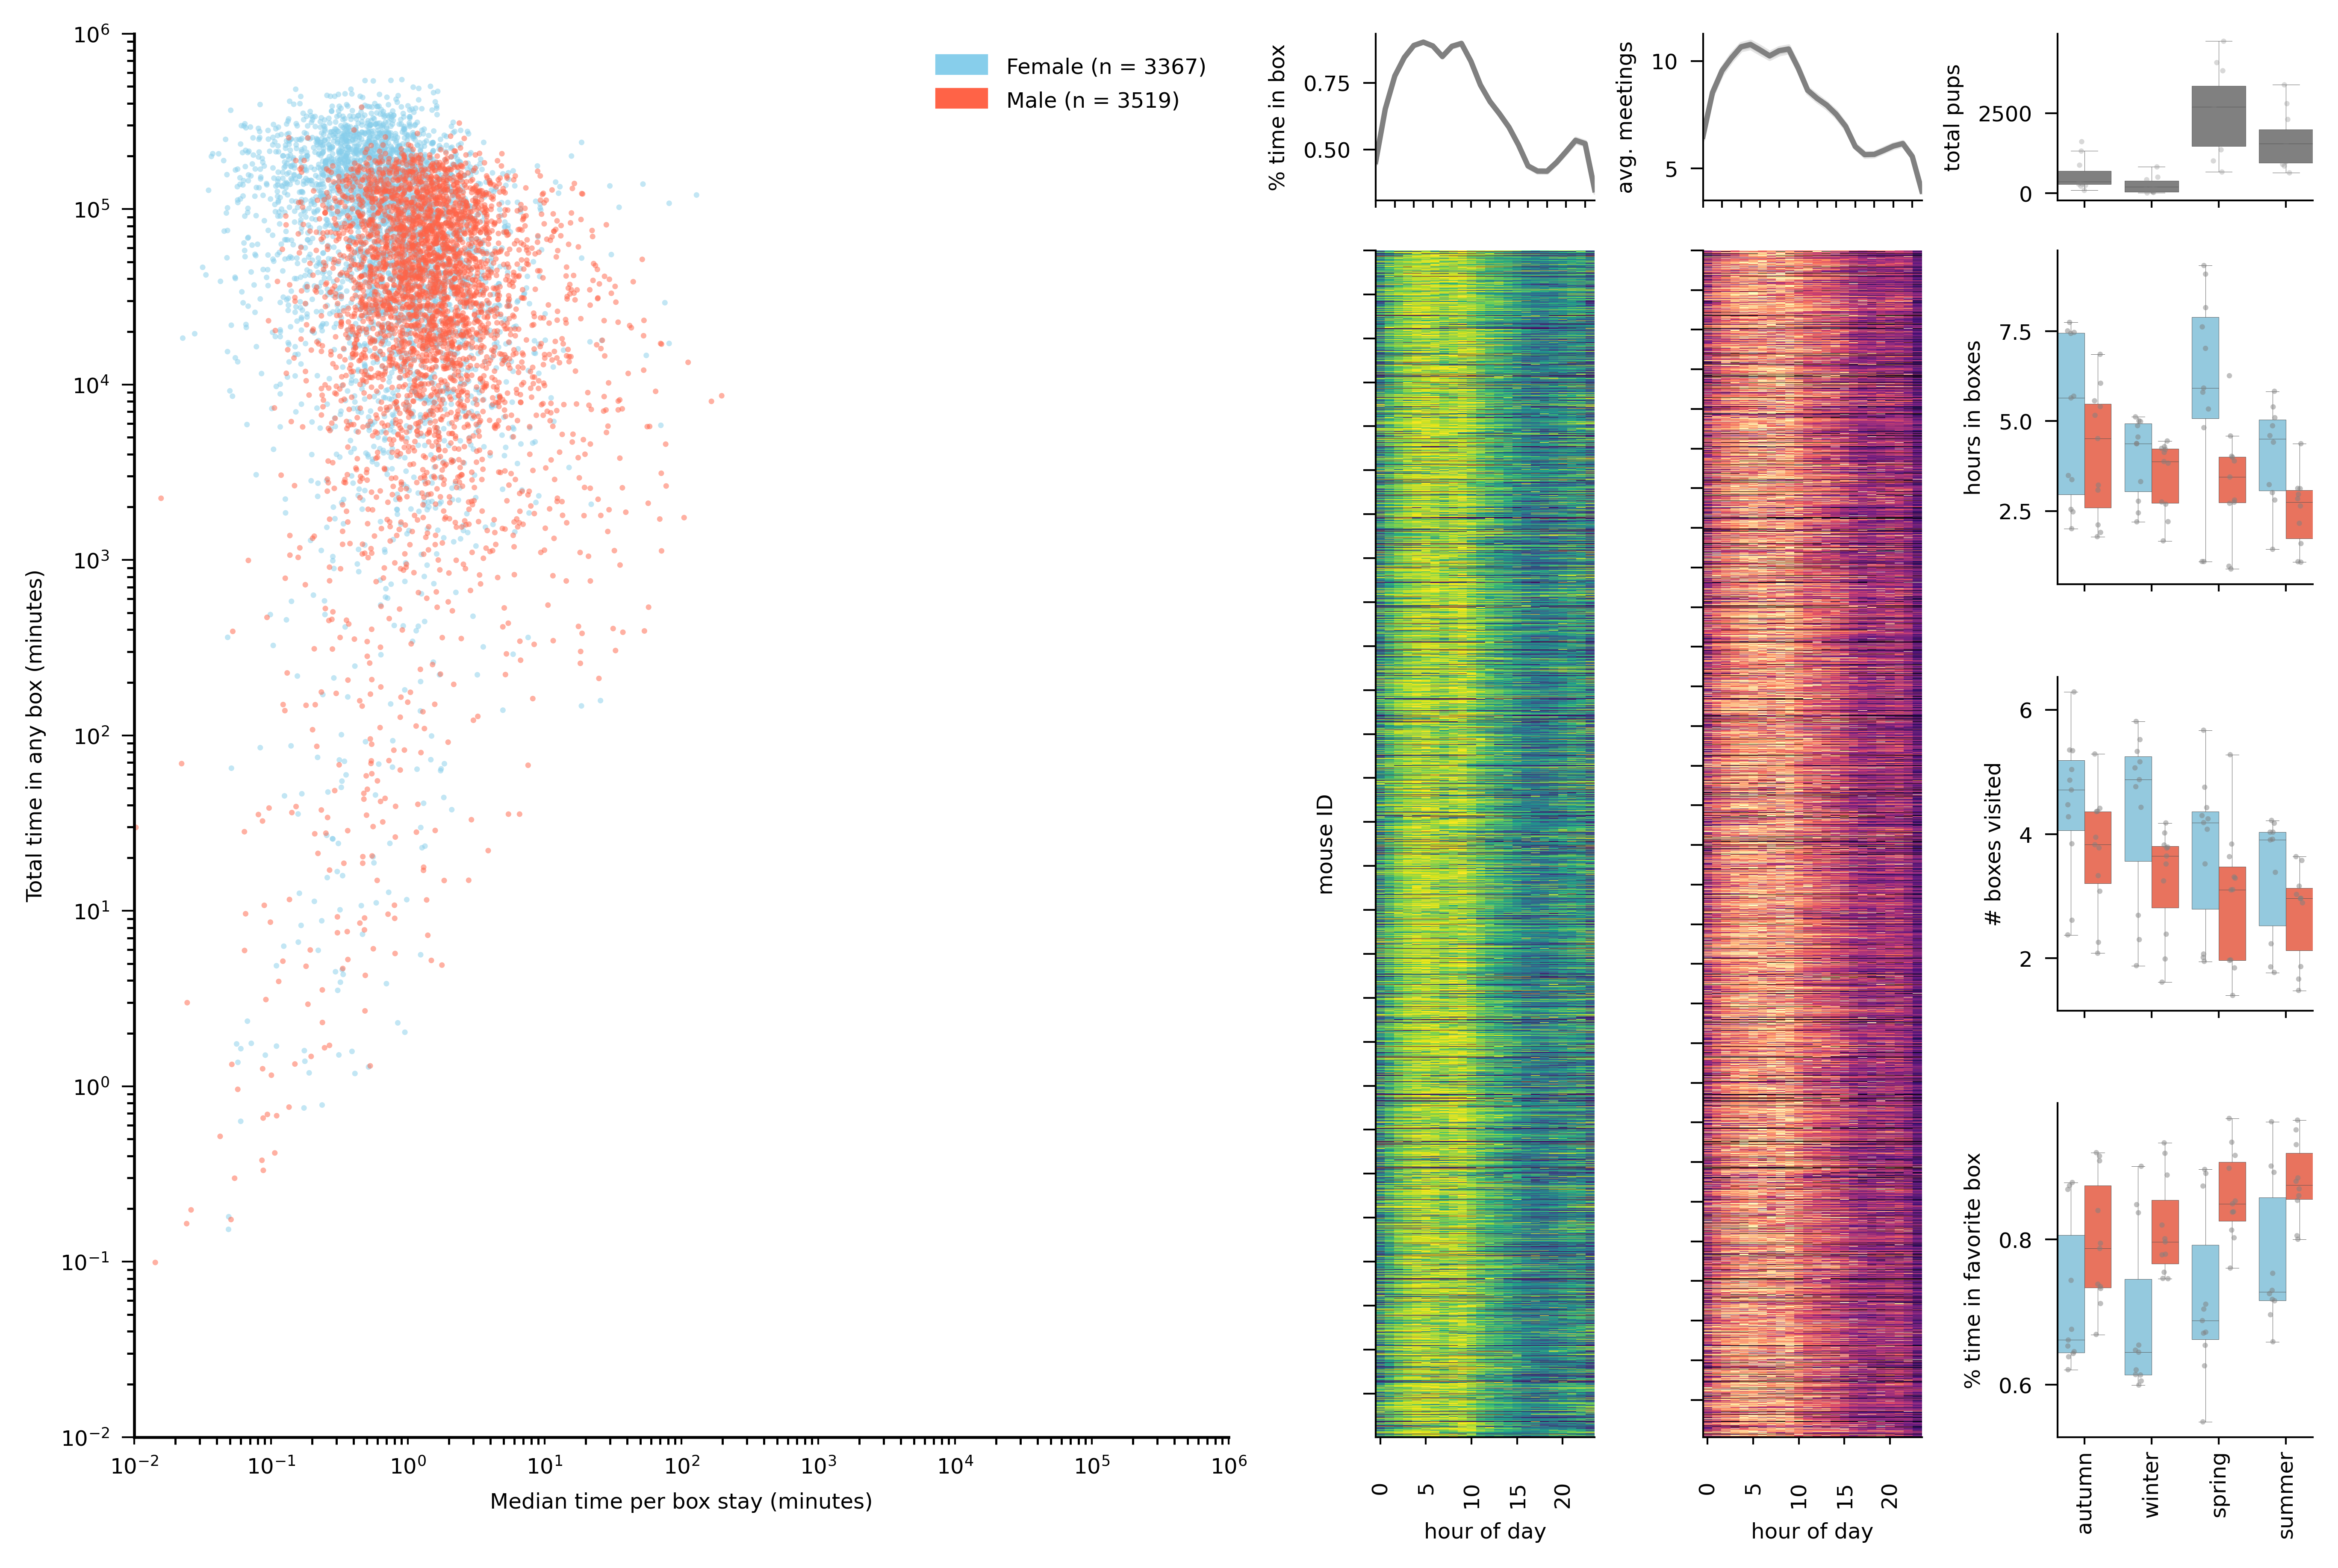

In [26]:
# save or not
save = False
path_to_save = ''

# colormaps
seasons_colors = os.path.join(root,'parameters', 'json_files','season_color_dict.json')
season_colormap = parameters.load_json(seasons_colors)

##################################################################################################

#set up the axes
fig, axes = plt.subplot_mosaic(mosaic="AAAAAA88DDEE;"\
                                      "AAAAAABBHH77;"\
                                      "AAAAAABBHH66;"\
                                      "AAAAAABBHH11",

                               figsize=[9,6], 
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.05,0.1,0.1,0.1],
                               "width_ratios": [1, 1, 1, 1, 1, 1, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7]},
                               dpi=600)
# plotting parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 40 # for panel F x-axis
dot_size = .5
dot_alpha = .5
text_location = 4000
nth_mouse = 499
    
 # turn off unused axes
# axes["9"].axis('off')
##################################################################################################
# panel A - stays by mouse
##################################################################################################

# plot

axes["A"].set_xscale('log')
axes["A"].set_yscale('log')

avg_stay_duration_and_total_stays = avg_stay_duration_and_total_stays.sort_values(by = 'sex').reset_index(drop = True)
sns.scatterplot(data=avg_stay_duration_and_total_stays, 
                x='avg_min_per_stay', 
                y='total_min_in_boxes', 
                hue = 'sex', 
                palette = sex_colors,
                alpha=0.5, 
                s = dot_size+2, 
                linewidth=0, 
                ax = axes["A"])
# prettify
labels = ['F', 'M']  
handles = [plt.Rectangle((0,0),1,1, color=sex_colors.get(label, 'grey')) for label in labels]
legend = axes["A"].legend(handles, labels, frameon=False, prop={'size': 'x-small'})
for i in range(len(legend.get_texts())):
    if i == 0:
        legend.get_texts()[i].set_text("Female"+" (n = "+str(num_unique_females_detected)+")")
    if i == 1:
        legend.get_texts()[i].set_text("Male"+" (n = "+str(num_unique_males_detected)+")")
    if i == 2:
        legend.get_texts()[i].set_text("Unknown")
    legend.get_texts()[i].set_fontsize(tick_label_fontsize)
    
for label in axes["A"].get_yticklabels():
    label.set_fontsize(tick_label_fontsize)   

for i, label in enumerate(axes["A"].get_xticklabels()):
        label.set_fontsize(tick_label_fontsize)  
        #label.set_y(label.get_position()[1] + 0.02)     

axes["A"].set_xlim([0.01,1000000])
axes["A"].set_ylim([0.01,1000000])
axes["A"].margins(x=0)
axes["A"].margins(y=0)
axes["A"].tick_params(width=0.5)
axes["A"].tick_params(axis= 'x', length=2)
axes["A"].xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto'))
axes["A"].yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto'))
axes["A"].set_ylabel('Total time in any box (minutes)', fontsize=tick_label_fontsize)
axes["A"].set_xlabel('Median time per box stay (minutes)', fontsize=tick_label_fontsize)


sns.despine(ax = axes["A"], left=False, bottom = False, right=True, top= True)
    

##################################################################################################
# panels 8 and B : occupancy by time of day for all individual mice
##################################################################################################      

data = total_stays_matrix_df_normalized.melt().rename(columns={'value':'hours_in_box'})

sns.lineplot(data = data, 
            x = 'hour_int', 
            y = 'hours_in_box', 
             estimator = 'median',
            color = 'grey',
            ax=axes["8"])

# axes["8"].set_ylim([0,1])
axes["8"].set_xticks(np.arange(0,24,2), labels = np.arange(0,24,2))
axes["8"].set_xlabel('')
axes["8"].set_xticklabels([])
axes["8"].set_ylabel('% time in box', fontsize = tick_label_fontsize)
plot.customize_axis(ax=axes["8"], 
                    ylim=None, 
                    xlim=None, 
                    xlab=None, 
                    ylab=None, 
                    rot_x_lab=False, 
                    fontsize = tick_label_fontsize)

sns.despine()

#randomize rows if you want
random_state = 123456
total_stays_matrix_df_normalized = total_stays_matrix_df_normalized.sample(frac=1,  random_state=random_state)

sns.heatmap(total_stays_matrix_df_normalized, 
            cmap='viridis', 
            annot=False, 
            ax=axes["B"], 
            cbar=False)
axes["B"].set_yticklabels([])
plot.customize_axis(ax=axes["B"], 
                    ylim=None, 
                    xlim=None, 
                    xlab=None, 
                    ylab=None, 
                    rot_x_lab=True, 
                    fontsize = tick_label_fontsize)

axes["B"].set_ylabel('mouse ID', fontsize = tick_label_fontsize)
axes["B"].set_xlabel('hour of day', fontsize = tick_label_fontsize)

#prettify
for ax in ["8", "B"]:
    axes[ax].margins(x=0)
    axes[ax].tick_params(width=0.5)
    axes[ax].tick_params(axis= 'x', length=2)
    for label in axes[ax].get_yticklabels():
        label.set_fontsize(tick_label_fontsize)   
    for i, label in enumerate(axes[ax].get_xticklabels()):
        label.set_fontsize(tick_label_fontsize)  
        label.set_y(label.get_position()[1] - 0.02)
        
##################################################################################################
# panel D and H - meetings by time of day for all individual mice
##################################################################################################

data = all_meets_matrix_df.melt().rename(columns={'value':'num_meets'})

sns.lineplot(data = data, 
            x = 'hour_int', 
            y = 'num_meets', 
             estimator = 'median',
            color = 'grey',
            ax=axes["D"])

# axes["D"].set_ylim([0,1])
axes["D"].set_xticks(np.arange(0,24,2), labels = np.arange(0,24,2))
axes["D"].set_xlabel('')
axes["D"].set_xticklabels([])
axes["D"].set_ylabel('avg. meetings', fontsize = tick_label_fontsize)
plot.customize_axis(ax=axes["D"], 
                    ylim=None, 
                    xlim=None, 
                    xlab=None, 
                    ylab=None, 
                    rot_x_lab=False, 
                    fontsize = tick_label_fontsize)

sns.despine()

# make the rows the same by using the same random_state to shuffle
all_meets_matrix_df_normalized = all_meets_matrix_df_normalized.sample(frac=1,  random_state=random_state)
sns.heatmap(all_meets_matrix_df_normalized, 
            cmap='magma', 
            annot=False, 
            ax=axes["H"], 
            cbar=False)
axes["H"].set_yticklabels([])
plot.customize_axis(ax=axes["H"], 
                    ylim=None, 
                    xlim=None, 
                    xlab=None, 
                    ylab=None, 
                    rot_x_lab=True, 
                    fontsize = tick_label_fontsize)

axes["H"].set_ylabel('')
axes["H"].set_xlabel('hour of day', fontsize = tick_label_fontsize)

#prettify
for ax in ["H", "D"]:
    axes[ax].margins(x=0)
    axes[ax].tick_params(width=0.5)
    axes[ax].tick_params(axis= 'x', length=2)
    for label in axes[ax].get_yticklabels():
        label.set_fontsize(tick_label_fontsize)   
    for i, label in enumerate(axes[ax].get_xticklabels()):
        label.set_fontsize(tick_label_fontsize)  
        label.set_y(label.get_position()[1] - 0.02)
    
    


##################################################################################################
# panel E - number pups by season
##################################################################################################

data = pups
order = ['autumn', 'winter', 'spring', 'summer']
data['season'] = pd.Categorical(data['season'], 
                                categories=order, 
                                ordered=True)
sns.stripplot(data = data, 
              x='season', 
              order = order, 
              color = 'grey', 
              s = dot_size+1, 
              alpha = 0.3,
              y = 'total_pups', 
              ax = axes["E"])
sns.boxplot(data = data, 
            x='season', 
            order = order,
            color = 'grey', 
            linewidth = 0.1, 
            y = 'total_pups', 
            showfliers = False, 
            ax = axes["E"])



# sns.boxplot(data = data, 
#             x='season', 
#             linewidth = 0.1, 
#             y = 'total_pups_discovered', 
#             ax = axes["E"])

axes["E"].set_ylabel('total pups', fontsize = tick_label_fontsize)
axes["E"].set_xlabel('', fontsize = tick_label_fontsize)
axes["E"].set_xticklabels('')

#prettify
for ax in ["E"]:
    axes[ax].margins(x=0)
    axes[ax].tick_params(width=0.5)
    axes[ax].tick_params(axis= 'x', length=2)
    for label in axes[ax].get_yticklabels():
        label.set_fontsize(tick_label_fontsize)   
    for i, label in enumerate(axes[ax].get_xticklabels()):
        label.set_fontsize(tick_label_fontsize)  
        label.set_y(label.get_position()[1] + 0.02)

sns.despine()

##################################################################################################
# panel 7 - hours in boxes by mouse
##################################################################################################

# plot
order = ['autumn', 'winter', 'spring', 'summer']

plot_7_data = stays_by_mouse_by_season_by_year
plot_7_data['total_hours_in_boxes_divided_by_100'] = (plot_7_data['total_secs_in_boxes'] / 3600) / 100
sns.stripplot(data = plot_7_data, 
              x = 'season',
              hue = 'sex',
              y = 'total_hours_in_boxes_divided_by_100',
              order = order,
              palette = {i:'grey' for i in ['M', 'F', float('NaN')]}, 
              dodge = True,
              ax = axes["7"], 
              s = dot_size+1, 
              alpha = dot_alpha)

sns.boxplot(data = plot_7_data, 
            x = 'season',
            hue = 'sex',
            order = order,
            y = 'total_hours_in_boxes_divided_by_100', 
            palette = sex_colors, 
            linewidth = 0.1, 
            showfliers = False,
            ax = axes["7"])

# Remove legends if they exist
if axes["7"].get_legend() is not None:
    axes["7"].get_legend().remove()

#prettify
#axes["7"].set_yscale('log')
axes["7"].set_ylabel('hours in boxes', fontsize = tick_label_fontsize)
axes["7"].set_xlabel('')
axes["7"].set_xticklabels('')

##################################################################################################
# panel 6 - number unique boxes visited by season and sex
##################################################################################################

data = total_boxes_df_by_year

# plot
order = ['autumn', 'winter', 'spring', 'summer']
    
sns.stripplot(data = data, 
              x = 'season', 
              hue = 'sex',
              y = 'boxes_visited',
              palette = {i:'grey' for i in ['M', 'F', float('NaN')]}, 
              order = order,
              dodge = True,
              ax = axes["6"], 
              s = dot_size + 1, 
              alpha = dot_alpha, legend =False)

sns.boxplot(data = data, 
            x = 'season', 
            hue = 'sex',
            y = 'boxes_visited', 
            palette = sex_colors, 
            linewidth = 0.1, 
            order = order,
            showfliers = False,
            ax = axes["6"])

#prettify
#axes["7"].set_yscale('log')
axes["6"].set_ylabel('# boxes visited', fontsize = tick_label_fontsize)
axes["6"].set_xlabel('')
axes["6"].set_xticklabels('')

##################################################################################################
# panel 1 - preference for favorite box by sex and season
##################################################################################################
#data = box_preferences_by_season[box_preferences_by_season['box_preference_rank'] == 0] #only consider favorite boxes
data = box_preferences_by_season_by_year
order = ['autumn', 'winter', 'spring', 'summer']

sns.stripplot(data = data, 
              x = 'season', 
              hue = 'sex',
              y = 'percent_time_in_box',
              palette = {i:'grey' for i in ['M', 'F', float('NaN')]}, 
              order = order,
              dodge = True,
              ax = axes["1"], 
              s = dot_size+1, 
              alpha = dot_alpha, legend =False)

sns.boxplot(data = data, 
            x = 'season', 
            hue = 'sex',
            y = 'percent_time_in_box', 
            palette = sex_colors, 
            linewidth = 0.1, 
            order = order,
            showfliers = False,
            ax = axes["1"])

# prettify
axes["1"].set_xlabel('', fontsize=tick_label_fontsize)
axes["1"].set_xticklabels(order, fontsize=tick_label_fontsize, rotation = 90)
axes["1"].set_ylabel('% time in favorite box', fontsize=tick_label_fontsize)
# axes["1"].set_ylim([0,1])

# prettify the box plots
for ax in ["7", "E", "6", "1"]:
    for spine in axes[ax].spines.values():
        spine.set_linewidth(0.5)
    sns.despine(ax = axes[ax])
    axes[ax].margins(x=0)
    axes[ax].tick_params(width=0.5)
    axes[ax].tick_params(axis= 'x', length=2)
    for label in axes[ax].get_yticklabels():
        label.set_fontsize(tick_label_fontsize)   
    for i, label in enumerate(axes[ax].get_xticklabels()):
        label.set_fontsize(tick_label_fontsize)  
        label.set_y(label.get_position()[1] + 0.02)
    if axes[ax].get_legend() is not None:
        axes[ax].get_legend().remove()

# save
if save:
    plt.savefig(os.path.join(path_to_save, 'Figure2_revision_v1.svg'))
    plt.savefig(os.path.join(path_to_save, 'Figure2_revision_v1.jpeg'), dpi = 600)

# Statistics

In [58]:
import statsmodels.stats.multicomp as multi
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from docx import Document
from docx.shared import Inches
from src import modelselection

In [59]:
statistics_dir = ''
save = False # if true, save statistics csvs and output to statistics_dir

## Panel D

In [60]:
data = pups
dependent_var = 'total_pups'
independent_var = 'season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure2_panelD'

# Ensure 'season' is treated as categorical and ordered
season_order = ['autumn', 'winter', 'spring', 'summer']
data[independent_var] = pd.Categorical(data[independent_var], categories=season_order, ordered=True)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()

# Generate and print the ANOVA table
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)
    

             df        sum_sq       mean_sq          F        PR(>F)
C(season)   3.0  3.350074e+07  1.116691e+07  15.375593  9.349701e-07
Residual   39.0  2.832473e+07  7.262752e+05        NaN           NaN
   group1  group2   meandiff   p-adj      lower      upper  reject
0  autumn  spring  1916.5455  0.0000   941.4450  2891.6459    True
1  autumn  summer  1062.0000  0.0282    86.8995  2037.1005    True
2  autumn  winter  -319.6091  0.8261 -1318.7898   679.5716   False
3  spring  summer  -854.5455  0.1039 -1829.6459   120.5550   False
4  spring  winter -2236.1545  0.0000 -3235.3352 -1236.9739    True
5  summer  winter -1381.6091  0.0035 -2380.7898  -382.4284    True


## Panel E

In [61]:
data = stays_by_mouse_by_season_by_year
dependent_var = 'total_hours_in_boxes_divided_by_100'
analysis_name = 'figure2_panelE'

model = ols(dependent_var + ' ~ C(season)*C(sex)', data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['season'] + '-' + data['sex']

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)

                    df      sum_sq    mean_sq          F    PR(>F)
C(season)          3.0   27.265212   9.088404   2.998353  0.035639
C(sex)             1.0   41.883603  41.883603  13.817809  0.000377
C(season):C(sex)   3.0   14.224097   4.741366   1.564223  0.204760
Residual          78.0  236.428298   3.031132        NaN       NaN
      group1    group2  meandiff   p-adj   lower   upper  reject
0   autumn-F  autumn-M   -0.8837  0.9324 -3.1960  1.4286   False
13  spring-F  spring-M   -2.6302  0.0148 -4.9425 -0.3179    True
22  summer-F  summer-M   -1.5683  0.4793 -3.9934  0.8569   False
27  winter-F  winter-M   -0.5165  0.9969 -2.8288  1.7958   False


## Panel F

In [62]:
data = total_boxes_df_by_year
dependent_var = 'boxes_visited'
analysis_name = 'figure2_panelF'

model = ols(dependent_var + ' ~ C(season)*C(sex)', data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['season'] + '-' + data['sex']

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)

                    df     sum_sq    mean_sq          F    PR(>F)
C(season)          3.0  13.732808   4.577603   3.903173  0.011843
C(sex)             1.0  14.269359  14.269359  12.167018  0.000803
C(season):C(sex)   3.0   0.573569   0.191190   0.163021  0.920942
Residual          78.0  91.477629   1.172790        NaN       NaN
      group1    group2  meandiff   p-adj   lower   upper  reject
0   autumn-F  autumn-M   -0.7675  0.7111 -2.2058  0.6708   False
13  spring-F  spring-M   -0.7688  0.7093 -2.2071  0.6695   False
22  summer-F  summer-M   -0.6289  0.8967 -2.1374  0.8796   False
27  winter-F  winter-M   -1.0766  0.2904 -2.5149  0.3617   False


## Panel G

In [63]:
data = box_preferences_by_season_by_year
dependent_var = 'percent_time_in_box'
analysis_name = 'figure2_panelG'

model = ols(dependent_var + ' ~ C(season)*C(sex)', data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['season'] + '-' + data['sex']

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)

                    df    sum_sq   mean_sq          F        PR(>F)
C(season)          3.0  0.076533  0.025511   3.035319  3.406382e-02
C(sex)             1.0  0.268285  0.268285  31.920691  2.513019e-07
C(season):C(sex)   3.0  0.012015  0.004005   0.476507  6.995455e-01
Residual          78.0  0.655569  0.008405        NaN           NaN
      group1    group2  meandiff   p-adj   lower   upper  reject
0   autumn-F  autumn-M    0.0771  0.5076 -0.0447  0.1988   False
13  spring-F  spring-M    0.1392  0.0140  0.0174  0.2609    True
22  summer-F  summer-M    0.1047  0.1895 -0.0230  0.2324   False
27  winter-F  winter-M    0.1253  0.0392  0.0035  0.2470    True
